# QDA AND LDA CLASSIFIERS ON MNIST AND SPAM DATASETS

by Maia Rosengarten <br/>
Summer 2017

# STEP 1: Visualizing Isocontours of Normal Distributions

In [643]:
import matplotlib
import numpy as np
from numpy import linalg as LA
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score

In [568]:
delta = 0.025
x = np.arange(-10.0, 10.0, delta)
y = np.arange(-10.0, 10.0, delta)
X, Y = np.meshgrid(x, y)

def plotContours(X, Y, distrb, title):
    plt.figure()
    CS = plt.contour(X, Y, distrb)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title(title + ' Isocontours')
    plt.show()

In [569]:
Z1 = mlab.bivariate_normal(X, Y, 1.0, 2.0, 1.0, 1.0, 0.0)
Z2 = mlab.bivariate_normal(X, Y, 2.0, 3.0, -1.0, 2.0, 1.0)
Z3_a = mlab.bivariate_normal(X, Y, 2.0, 1.0, 0.0, 2.0, 1.0)
Z3_b = mlab.bivariate_normal(X, Y, 2.0, 1.0, 2.0, 0.0, 1.0)
Z3 = Z3_a - Z3_b
Z4_a = mlab.bivariate_normal(X, Y, 2.0, 1.0, 0.0, 2.0, 1.0)
Z4_b = mlab.bivariate_normal(X, Y, 2.0, 3.0, 2.0, 0.0, 1.0)
Z4 = Z4_a - Z4_b
Z5_a = mlab.bivariate_normal(X, Y, 2.0, 1.0, 1.0, 1.0, 0.0)
Z5_b = mlab.bivariate_normal(X, Y, 2.0, 2.0, -1.0, -1.0, 1.0)
Z5 = Z5_a - Z5_b

two = [Z1, Z2, Z3, Z4, Z5]
prob = ['2a', '2b', '2c', '2d', '2e']

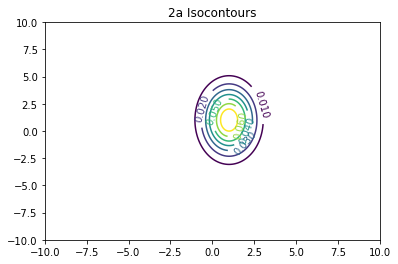

In [570]:
plotContours(X, Y, Z1, '2a')

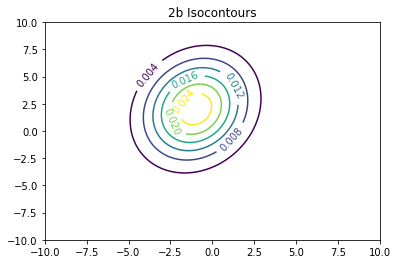

In [571]:
plotContours(X, Y, Z2, '2b')

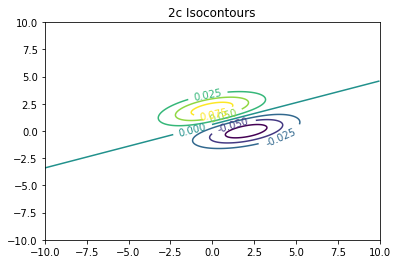

In [572]:
plotContours(X, Y, Z3, '2c')

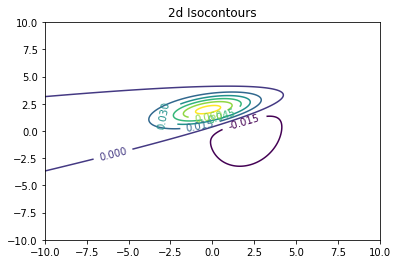

In [573]:
plotContours(X, Y, Z4, '2d')

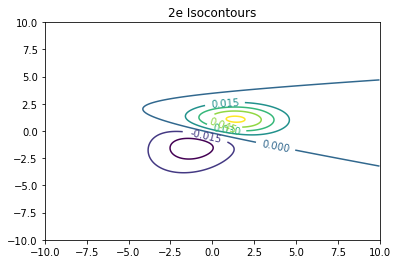

In [574]:
plotContours(X, Y, Z5, '2e')

# Step 2: Calculating Eigenvectors of Gaussian Covariance Matrix

In [575]:
X1 = np.random.normal(3, 3, 100)
normal = np.random.normal(4, 2, 100)
X2 = np.array([])
for x1, sample in zip(X1, normal):
    x2 = 0.5*x1 + sample
    X2 = np.append(X2, [x2])

# A: MEAN 

In [576]:
print("3a. Calculating Means in R^2:")
mu1 = np.mean(X1)
mu2 = np.mean(X2)
muBiv = np.array([mu1, mu2])
print("mu1: " + str(mu1))
print("mu2: " + str(mu2))
print("muBiv: " + str(muBiv))

3a. Calculating Means in R^2:
mu1: 3.54764716836
mu2: 5.86727756435
muBiv: [ 3.54764717  5.86727756]


# B: COV MATRIX

In [577]:
print("3b. Calculating 2x2 Covariance Matrix")
covMatrix = np.cov(X1, X2)
print("Covariance matrix:")
print(covMatrix)

3b. Calculating 2x2 Covariance Matrix
Covariance matrix:
[[ 7.66608196  4.1407418 ]
 [ 4.1407418   6.94112995]]


# C: EIGENVALUES/VECTORS

In [578]:
print("3c. Computing eigenvalues/eigenvectors")
eigenVal, eigenVect = LA.eig(covMatrix)
print('Eigenvalues:')
print(eigenVal)
print('Eigenvectors:')
print(eigenVect)

3c. Computing eigenvalues/eigenvectors
Eigenvalues:
[ 11.46018285   3.14702905]
Eigenvectors:
[[ 0.73729418 -0.67557183]
 [ 0.67557183  0.73729418]]


# D: PLOTS

3d. Plotting (X1, X2) And Eigenvectors


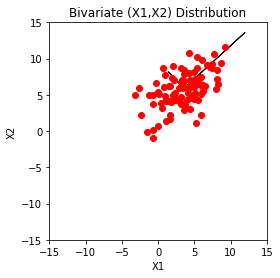

In [579]:
print("3d. Plotting (X1, X2) And Eigenvectors")
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(X1, X2, 'ro')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis([-15,15,-15,15])
plt.title("Bivariate (X1,X2) Distribution")
arrow1 = plt.arrow(mu1, mu2, eigenVect[0][0] * eigenVal[0], eigenVect[1][0] * eigenVal[0])
arrow2 = plt.arrow(mu1, mu2, eigenVect[0][1] * eigenVal[1], eigenVect[1][1] * eigenVal[1])
plt.show()

# E: Rotatated Sample Points

3e. Plotting Rotated Sample Points


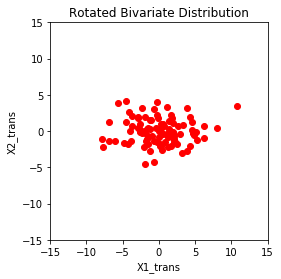

In [580]:
print("3e. Plotting Rotated Sample Points")
plt.gca().set_aspect('equal', adjustable='box')
rot = eigenVect.T
x1_center = [x1 - mu1 for x1 in X1]
x2_center = [x2 - mu2 for x2 in X2]
combined = np.stack((x1_center, x2_center))
transform = np.dot(rot, combined)

plt.plot(transform[0] , transform[1], 'ro')
plt.xlabel('X1_trans')
plt.ylabel('X2_trans')
plt.axis([-15,15,-15,15])
plt.title("Rotated Bivariate Distribution")
plt.show()

# STEP 3: Fitting Gaussian Classifiers To Digits (MNIST) and SPAM Data Sets

In [583]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.set_printoptions(threshold=np.nan)
import scipy as sp
from scipy import io
import sklearn
from sklearn.preprocessing import normalize
import csv
import math
from sklearn.model_selection import train_test_split

In [584]:
def makeMuAndSigmaAry(trainData, trainLabels, epsilon, method, numFeatures, numClasses):
    '''
    Compute and return array of mu's and array of sigmas, one for each class
    Args:
        trainData (ndarray) - (nxd) design matrix of n samples d features
        trainLabels(ndarray) - (nx1) array of labels corresponding to training set
    '''
    aryMu = []
    aryCovMat = []
    intNumSamples = trainData.shape[0]
    for c in range(numClasses):
        samples = np.array([trainData[i] for i in range(intNumSamples) if trainLabels[i]==c])
        mu = np.sum(samples, axis=0)/len(samples)
        aryMu.append(mu)
        cov = np.cov(samples, rowvar=False)
        aryCovMat.append(cov + epsilon*np.identity(numFeatures))   
    return aryMu, aryCovMat

In [585]:
def makeGaussianPerClass(aryCovMat, aryMu, numClasses):
    aryDistrs=[]
    for c in range(numClasses):
        aryDistrs.append(sp.stats.multivariate_normal(mean=aryMu[c], cov=aryCovMat[c]))
    return aryDistrs

In [586]:
def predictBuiltInQDA(aryMu, aryCovMat, validData, numClasses):
    aryDistrs = makeGaussianPerClass(aryCovMat, aryMu, numClasses)
    aryPredict=[]
    for i in range(len(validData)):
        probDist = []
        for j in range(numClasses):
            probDist.append(aryDistrs[j].pdf(validData[i]))
        maxIndex = probDist.index(max(probDist))
        aryPredict.append(maxIndex)
    return aryPredict

In [588]:
def predictLDA(aryMu, sigmaLDA, validData, numClasses): 
    '''
    Compute and return list of predictions using linear discriminant function for LDA
    Args:
        aryMu (ndarray) - list of (dx1) means
        sigmaLDA (ndarray) - (dxd) covariance matrix averaged over classes
        validData (ndarray) - (nxd) validation data to classify
    
    '''
    aryConstants = []
    aryCoeffX = []
    aryPredict=[]
    aryMuT = computeMuTranspose(aryMu, numClasses)
    sigmaInv = np.linalg.inv(sigmaLDA)
    for c in range(numClasses):
        muSigma = np.dot(aryMuT[c], sigmaInv)
        constant = -1/2*np.dot(muSigma, aryMu[c])
        aryConstants.append(constant)
        aryCoeffX.append(muSigma)
    for i in range(len(validData)):
        probDist = []
        for j in range(numClasses):
            prob = np.dot(aryCoeffX[j],validData[i]) + aryConstants[j]
            probDist.append(prob)
        maxIndex = probDist.index(max(probDist))
        aryPredict.append(maxIndex)
    return aryPredict

In [590]:
def makeSigmaLDA(aryCovMat, numClasses, numFeatures):
    '''
    Compute and return average covariance matrix for LDA
    Args:
        aryCovMat (ndarray) - list of covariance matrices to average, one for each class
        numClasses (int) - number of classes for classification
    '''
    sigmaLDA = np.zeros(shape=(numFeatures, numFeatures))
    for c in range(numClasses):
        sigmaLDA += aryCovMat[c]
    return sigmaLDA/numClasses

In [591]:
def computeMuTranspose(aryMu, numClasses):
    '''
    Computes and returns list of transposed means, one for each class
    Args:
        aryMu (ndarray) - list of (dx1) means to tranpose
    '''
    aryMuT=[]
    for c in range(numClasses):
        aryMuT.append(aryMu[c].T)
    return aryMuT

In [593]:
def computeSigmaInv(aryCovMat, numClasses):
    '''
    Computes and returns list of inverse covariance matrices, one for each class
    Args:
        aryCovMat (ndarray) - list of (dxd) covariance matrices to take inverse of
    '''
    arySigInv = []
    for c in range(numClasses):
        arySigInv.append(aryCovMat[c].T)
    return arySigInv

In [596]:
def parseData2TrainAndValid(data, sizeValidSet, sizeTestSet):
    '''
    Splits data set into trainData, trainLabels, validData, validLabels and returns
    Args:
        data (ndarray) - set of data   
        sizeValidSet (int) - size of validation set to hold out
    '''
    if sizeValidSet+sizeTestSet > len(data):
        print('Cant train on that many samples, please try again')
        return
    np.random.shuffle(data)
    trainData = data[sizeValidSet:sizeValidSet+sizeTestSet, :-1]
    trainLabels = data[sizeValidSet:sizeValidSet+sizeTestSet, -1]
    validData = data[:sizeValidSet, :-1]
    validLabels= data[:sizeValidSet, -1]
    return trainData, trainLabels, validData, validLabels

In [597]:
def normalizeData(trainData, validData):
    '''
    Normalizes and returns training and validation sets
    Args:
        trainData (ndarray) - (nxd) set of training data to normalize
        validData (ndarry) - (nxd) set of validation data to normalize
    '''
    trainData = trainData.astype(float)
    validData = validData.astype(float)
    for i in range(len(trainData)):
        trainData[i] = trainData[i]/np.linalg.norm(trainData[i])
    for i in range(len(validData)):
        validData[i] = validData[i]/np.linalg.norm(validData[i])
    return trainData, validData

In [607]:
def computeErrorRate(predictions, validLabels):
    '''
    Compute and plot error rate of LDA classification
    
    '''
    error = 0
    for i in range(len(predictions)):
        if predictions[i]!=validLabels[i]:
            error+=1
    error/=len(validLabels)
    
    return error

In [626]:
def doEverything(method, trainData, trainLabels, validData, validLabels, aryTrainSetSizes, numClasses, epsilon):
    '''
    Calculates and plots error rate of predictions using either LDA or QDA for given set of data.
    Returns zipped tuple (errors, aryTrainSetSizes)
    Args:
        method (str) - either LDA or QDA
        path (str) - the path to load the data from
        key (str) - the key used to index into the dictionary returned by sp.io.loadmat, given path
        sizeValidSet (int) - number of samples to hold out for validation
        sizeTrianSet (int lst) - lst of sample sizes to train model on
        numClasses (int) - number of classes for classification
    '''
    print(str(method) + ' on ' + str(sizeValidSet) + ' samples')
    aryErrors = []
    predictions = []
    for i in aryTrainSetSizes:
        numFeatures = trainData.shape[1]
        aryMu, aryCovMat = makeMuAndSigmaAry(trainData[:i, :], trainLabels[:i], epsilon, method, numFeatures, numClasses)
        if method=='LDA':
            sigma = makeSigmaLDA(aryCovMat, numClasses, numFeatures)
            predictions = predictLDA(aryMu, sigma, validData, numClasses)
        else:
            predictions = predictBuiltInQDA(aryMu, aryCovMat, validData, numClasses)
        error = computeErrorRate(predictions, validLabels)
        aryErrors.append(error)
    
    print('SampleSize : error rate')
    for i, j in zip(aryTrainSetSizes, aryErrors):
        print(str(i) + ' : ' + str(j * 100) + '%')
    
    return predictions, aryErrors

In [600]:
def doEverythingKaggle(method, trainData, trainLabels, testData, numClasses, epsilon):
    '''
    Calculates and plots error rate of predictions of testData using either LDA or QDA for given set of data.
    Returns zipped tuple (errors, aryTrainSetSizes)
    Args:
        method (str) - either LDA or QDA
        path (str) - the path to load the data from
        key (str) - the key used to index into the dictionary returned by sp.io.loadmat, given path
        sizeValidSet (int) - number of samples to hold out for validation
        sizeTrianSet (int lst) - lst of sample sizes to train model on
        numClasses (int) - number of classes for classification
    '''
    aryErrors = []
    predictions = []
    numFeatures = trainData.shape[1]
    aryMu, aryCovMat = makeMuAndSigmaAry(trainData, trainLabels, epsilon, method, numFeatures, numClasses)
    if method=='LDA':
        sigma = makeSigmaLDA(aryCovMat, numClasses, numFeatures)
        predictions = predictLDA(aryMu, sigma, testData, numClasses)
    else:
        predictions = predictBuiltInQDA(aryMu, aryCovMat, testData, numClasses)
    return predictions

In [601]:
def generateCsv(aryPredictions, strCsvName):
    '''
    Writes predictions of testSet to csv file
    Args:
        aryPredictions (ndarray) - (nx1)-array of predictions given size n test (or valid) set
        strCsvName (str) - name of csv file to write to
    '''
    with open(strCsvName + '.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        for i in range(len(aryPredictions)):
            writer.writerow([i, aryPredictions[i]])
    csvfile.close()

In [612]:
def plotError(arySampleSizes, aryErrorRate, title):
    ''' 
    Plots error_rate of predictions
    Args 
        arySampleSizes (np array) - list of training set sample sizes
        aryErrorRate (np array) - list of corresponding error rates
        title (str) - title of the plot
    Return: plots accuracy, returns None
    '''
    plt.plot(arySampleSizes, aryErrorRate, 'ro')
    plt.xlabel('Training Data Sample Sizes')
    plt.ylabel('Error Rate')
    plt.title(title)
    plt.show()

# 3A: Fit Gaussians to Digits

In [604]:
path='mnist/train.mat'
data=sp.io.loadmat(path)
np.random.shuffle(train)
train = data['trainX']
trainData= train[:, :-1]
trainLabels=train[:, -1]
epsilon = 0.05
numClasses = 10

trainData, validData, trainLabels, validLabels = train_test_split(trainData, trainLabels, test_size=10000, random_state=42)
sklearn.preprocessing.normalize(trainData.astype(float))
sklearn.preprocessing.normalize(validData.astype(float))

numFeatures = trainData.shape[1]
aryMu, aryCovMat = makeMuAndSigmaAry(trainData, trainLabels, epsilon, method, numFeatures, numClasses)
aryGaussDistrs = makeGaussianPerClass(aryCovMat, aryMu, numClasses)

# 3B: Cov Matrix for Digit '4'

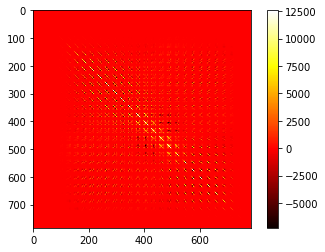

In [605]:
from numpy import corrcoef, sum, log, arange
from numpy.random import rand
from pylab import pcolor, show, colorbar, xticks, yticks

sigma = aryCovMat[4]
plt.imshow(sigma, cmap='hot', interpolation='None')
plt.colorbar()
plt.show()

# 3C: MNIST LDA

In [1]:
path='mnist/train.mat'
data=sp.io.loadmat(path)
np.random.shuffle(data)
train = data['trainX']
trainData= train[:, :-1]
trainLabels=train[:, -1]
epsilon = 0.05
aryTrainSizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
numClasses = 10

trainData, validData, trainLabels, validLabels = train_test_split(trainData, trainLabels, test_size=10000, random_state=42)
sklearn.preprocessing.normalize(trainData.astype(float))
sklearn.preprocessing.normalize(validData.astype(float))

method = 'LDA'
predictions, aryErrors = doEverything(method, trainData, trainLabels, validData, validLabels, aryTrainSetSizes, numClasses, epsilon)

NameError: name 'sp' is not defined

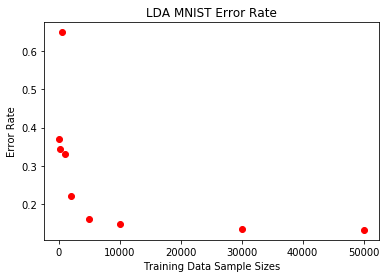

In [613]:
title = "LDA MNIST Error Rate"
error = computeErrorRate(predictions, validLabels)
plotError(aryTrainSizes, aryErrors, title)

# 3D: MNIST QDA

In [628]:
#MNIST QDA
path='mnist/train.mat'
data=sp.io.loadmat(path)
np.random.shuffle(train)
train = data['trainX']
trainData= train[:, :-1]
trainLabels=train[:, -1]
epsilon = 0.05
aryTrainSizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
numClasses = 10

trainData, validData, trainLabels, validLabels = train_test_split(trainData, trainLabels, test_size=10000, random_state=42)
trainData, validData = normalizeData(trainData, validData)
method='QDA'
predictions, aryErrors = doEverything(method, trainData, trainLabels, validData, validLabels, aryTrainSizes, numClasses, epsilon)

QDA on 10000 samples
SampleSize : error rate
100 : 24.19%
200 : 17.119999999999997%
500 : 14.52%
1000 : 13.469999999999999%
2000 : 13.450000000000001%
5000 : 13.370000000000001%
10000 : 13.43%
30000 : 13.84%
50000 : 13.81%


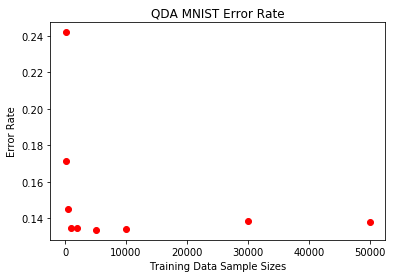

In [616]:
title = "QDA MNIST Error Rate"
error = computeErrorRate(predictions, validLabels)
plotError(aryTrainSizes, aryErrors, title)

# STEP 4: VALIDATION ACCURACIES 

# A: VALIDATION ACCURACY OF LDA CLASSIFIER ON  MNIST DATA

In [672]:
path2Train='mnist/train.mat'
path2Test ='mnist/test.mat'
dataTrain=sp.io.loadmat(path2Train)
dataTest=sp.io.loadmat(path2Test)

testData = dataTest['testX']
train = dataTrain['trainX']
trainData = train[:, :-1]
trainLabels = train[:, -1]

method='LDA'
epsilon = 0.05
numClasses = 10

sklearn.preprocessing.normalize(trainData.astype(float), axis=1)
sklearn.preprocessing.normalize(testData.astype(float), axis=1)

predictions = doEverythingKaggle(method, trainData, trainLabels, testData, numClasses, epsilon)

strCsvName = 'mnistShuffleDuffle'
generateCsv(predictions, strCsvName)

In [674]:
score = 0.87580

print('Kaggle submission score for MNIST: ' + str(score * 100) + "%")

Kaggle submission score for MNIST: 87.58%


# B: VALIDATION ACCURACY OF LDA CLASSIFER ON SPAM DATA

In [619]:
numClasses = 2
epsilon = 0.05
path='dist/spam_data.mat'
data=sp.io.loadmat(path)
trainData = data['training_data']
trainLabels = data['training_labels']
combineTrain = np.concatenate((trainData, trainLabels.T), axis=1)
np.random.shuffle(combineTrain)
trainData, trainLabels = combineTrain[:, :-1], combineTrain[:, -1]
trainData, validData, trainLabels, validLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=42)
sklearn.preprocessing.normalize(trainData)
sklearn.preprocessing.normalize(validData)
method = 'LDA'
predictions = doEverythingKaggle(method, trainData, trainLabels, validData, numClasses, epsilon)

In [622]:
error = computeErrorRate(predictions, validLabels)
print('OPTIMUM PREDICTION RATE: ' + str((1-error) * 100) + '%')

OPTIMUM PREDICTION RATE: 75.19510651761232%


# C: VALIDATION ACCURACY OF QDA ON SPAM DATA

In [623]:
from sklearn.model_selection import cross_val_score, KFold
numClasses = 2
epsilon = 0.05
path='dist/spam_data.mat'
data=sp.io.loadmat(path)
trainData = data['training_data']
trainLabels = data['training_labels']
combineTrain = np.concatenate((trainData, trainLabels.T), axis=1)
np.random.shuffle(combineTrain)
trainData, trainLabels = combineTrain[:, :-1], combineTrain[:, -1]
trainData, validData, trainLabels, validLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=42)
sklearn.preprocessing.normalize(trainData)
sklearn.preprocessing.normalize(validData)
method = 'QDA'
predictions = doEverythingKaggle(method, trainData, trainLabels, validData, numClasses, epsilon)

In [624]:
error = computeErrorRate(predictions, validLabels)
print('OPTIMUM PREDICTION RATE: ' + str((1-error) * 100) + '%')

OPTIMUM PREDICTION RATE: 68.76186458553049%


# LAST STEP: TESTING ON KAGGLE: LDA ON SPAM

In [625]:
path='dist/spam_data.mat'
data=sp.io.loadmat(path)

testData = data['test_data']
trainData = data['training_data']
trainLabels = data['training_labels']
combineTrain = np.concatenate((trainData, trainLabels.T), axis=1)
np.random.shuffle(combineTrain)
trainData, trainLabels = combineTrain[:, :-1], combineTrain[:, -1]

sklearn.preprocessing.normalize(trainData)
sklearn.preprocessing.normalize(testData)

method='LDA'
epsilon = 0.05
numClasses = 2
nameSet = 'spam'
predictions = doEverythingKaggle(method, trainData, trainLabels, testData, numClasses, epsilon)
generateCsv(predictions, 'spamMonday')

In [676]:
score = 0.76080
print('Kaggle submission score for SPAM (LDA): ' + str(score * 100) + "%")

Kaggle submission score for SPAM (LDA): 76.08%
